In [79]:
import numpy as np
import sympy as sp
import math
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.interpolate import UnivariateSpline
from scipy.integrate import simps
from scipy.optimize import fsolve
from scipy.integrate import solve_ivp
from scipy.optimize import minimize_scalar

# Given data
q_l0 = 38.7 #[kW/m] Peak linear power
t_cycle = 360 #[days] Length of cycle

# Neutronic specifications
phi_0 = 6.1e15 #[n/cm^2/s] Neutron flux at peak power

# Thermo-hydraulic specifications
pitch = 8.275 #[mm] Pin pitch
T_co_in_C = 395 #[°C] Coolant inlet temperature
P_co_in = 0.1 #[MPa] Coolant inlet pressure
m_co_in = 0.049 #[kg/s] Coolant mass flow rate

# Fuel pin specifications
H_act = 850 #[mm] Fuel column height
D_fuel_out = 5.42 #[mm] Fuel pellet outer diameter
H_fuel = 7 #[mm] Fuel pellet height
TD_fuel = 11.31 #[g/cm^3] Fuel theoretical density
rho_fuel = 0.945*TD_fuel #[g/cm^3] Fuel density %TD
D_grain = 10 #[10^-6 m] Fuel grain diameter
r_OM = 1.957 #[O/M] Oxygen to metal ratio
D_clad_out = 6.55 #[mm] Cladding outer diameter
P_gas_0 = 0.1 #[MPa] Initial pressure of filling gas
T_gas_0 = 20 #[°C] Initial temperature of filling gas

In [80]:
# Calculation of burnup
N_pellet = math.floor((H_act/H_fuel)) #[/] Number of pellets per column
V_pellet = np.pi*(D_fuel_out**2)/4*H_fuel #[mm^3] Volume of a single pellet
rho_fuel = 0.945*TD_fuel*1e3 #[kg/m^3] Fuel density %TD
V_fuel = N_pellet*V_pellet*1e-9 #[m^3] Total fuel volume per fuel rod
m_HM = rho_fuel*V_fuel/1000 #[ton-HM] Weight of fuel material per fuel rod
beta = (q_l0/1e6)*(H_act/1000)*t_cycle/m_HM #[GWd/t_HM]

print(f"Number of pellets per fuel rod: {N_pellet:.2f}")
print(f"Volume of pellet: {V_pellet:.2f} [mm^3]")
print(f"Weight of fuel material per fuel rod {m_HM:.6f} [ton]")
print(f"Burnup of fuel: {beta:.2f} [GWd/t-HM]")

Number of pellets per fuel rod: 121.00
Volume of pellet: 161.51 [mm^3]
Weight of fuel material per fuel rod 0.000209 [ton]
Burnup of fuel: 56.70 [GWd/t-HM]


The first task was to find an explicit expresion for the linear power as a function of z.

The linear power for a symmetric system is:

\begin{equation}
q_l(z) = q_{l0} \cdot cos(\frac{\pi z}{H_{ext}})
\end{equation}

Where,

- $q_{l0}$ is the peak power at the midplane of the fuel pin (z=0). It is assumed that the given peak power is located in the outer surface of the cladding, i.e., $q_{l0} = 38.7 [kW/m]$ when r = $r_{clad,out}$.

- $H_{ext}$ is the extrapolated boundary in [m].

Given that the nodalization for the peak power factors corresponds to a range and not a single value of "z". The fitted curve is valid when it crosses the top of the histogram.

Extrapolated boundary (H_ext): 1.21 [m]


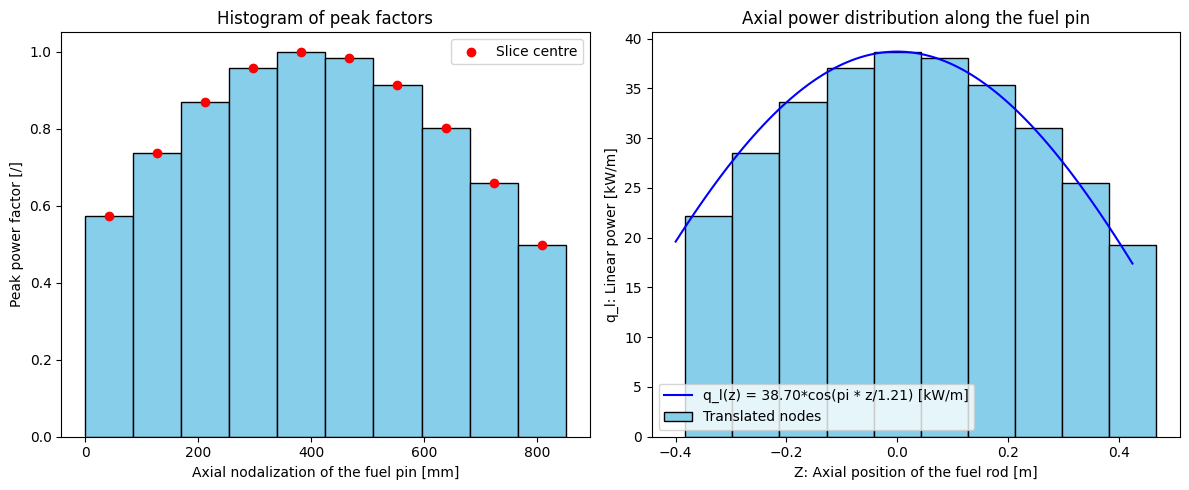

In [81]:
# Axial nodalization of fuel pin
H_nod = np.array([42.5, 127.5, 212.5, 297.5, 382.5, 467.5, 552.5, 637.5, 722.5, 807.5]) #[mm] Center of slice from bottom
H_nod_c = (H_nod - 382.5) / 1000 #[m] Corrected position of nodes from center of fuel pin
q_nod_f = np.array([0.572, 0.737, 0.868, 0.958, 1.000, 0.983, 0.912, 0.802, 0.658, 0.498]) #[/] Peak power factors

# Define a symmetric peak power function along the fuel pin
def q_l_f(z, H_ext):
    return q_l0 * np.cos(np.pi * z / H_ext)

# Extrapolated boundary
initial_guess = [1]  # Initial guess for H_ext
H_ext_opt, _ = curve_fit(q_l_f, H_nod_c, q_l0*q_nod_f, p0 = initial_guess)
H_ext = H_ext_opt[0] # [m] Optimized extrapolated boundary
print(f"Extrapolated boundary (H_ext): {H_ext:.2f} [m]")

# Plot the results
z_fit = np.linspace(-0.4, max(H_nod_c), 100)
q_fit = q_l_f(z_fit, H_ext_opt[0])

# Create a figure with two subplots arranged in 1 row and 2 columns
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Histogram of the given peak factor power vs height from bottom
ax1.bar(H_nod, q_nod_f, width=85, color='skyblue', edgecolor='black')
ax1.scatter(H_nod, q_nod_f, label="Slice centre", color="red")
ax1.set_title('Histogram of peak factors')
ax1.set_xlabel('Axial nodalization of the fuel pin [mm]')
ax1.set_ylabel('Peak power factor [/]')
ax1.legend()

# Validation of the fitted function
ax2.bar(H_nod_c, q_l0*q_nod_f, width=0.085, label = 'Translated nodes',color='skyblue', edgecolor='black')
ax2.plot(z_fit, q_fit, label=f"q_l(z) = {q_l0:.2f}*cos(pi * z/{H_ext:.2f}) [kW/m]", color="blue")
ax2.set_title('Axial power distribution along the fuel pin')
ax2.set_xlabel("Z: Axial position of the fuel rod [m]")
ax2.set_ylabel("q_l: Linear power [kW/m]")
ax2.legend()

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

# Linear power function along the fuel pin
def q_l(z):
    return q_l0 * np.cos(np.pi * z / H_ext) #[kW/m]

**Mass and Energy Balance in the coolant**

(1) Calculation of total power per fuel pin in [kW]

\begin{equation}
Q_{pin} = \int_{\frac{-H_{ext}}{2}}^{\frac{H_{ext}}{2}} q_l(z)dz
Q_{pin} = q_{l0}\frac{2 H_{ext}}{pi}
\end{equation}

(2) Calculation of outlet coolant temperature by iterative process:

The removed heat by the coolant $Q_{in}$ corresponds to $1/2$ of the $Q_{pin}$.
We define:

\begin{equation}
T_{co,avg} = \frac{T_{co,in} + T_{co,out}}{2}
\end{equation}

\begin{equation}
cp_{co} (T_{co,avg}) = 1608 - 0.7481 ⋅ T_{co,avg} + 3.929 \cdot 10^{-4} ⋅ T_{co,avg}^2
\end{equation}

\begin{equation}
T_{co,out} = \frac{Q_{in}}{m_{co,in} ⋅ cp_{co} (T_{co,avg})} + T_{co,in}
\end{equation}

In [82]:
#MASS AND ENERGY BALANCE IN THE COOLANT

# Input values
T_co_in_K = T_co_in_C + 273.15 #[K] Coolant inlet temperature

# Total power per fuel rod
Q_pin = 2 * q_l0 * H_ext / np.pi  #[kW] Total power per fuel rod
print(f'Total power per fuel rod (Q_pin): {Q_pin:.2f} [kW]')

# Outlet temperature of the coolant
Q_in = Q_pin / 2 #[kW] Total power to be removed in the channel
T_co_out_K = T_co_in_K + 50  #[K] Initial guess for the outlet temperature of the coolant
print(f'Total power to be removed by the coolant (Q_in): {Q_in:.2f} [kW]')

for _ in range(1000):
    T_co_avg_K = (T_co_in_K + T_co_out_K) / 2 #[K] Average temperature of the coolant
    cp_co_avg = 1608 - 0.7481 * T_co_avg_K + 3.929e-4 * T_co_avg_K**2 #[J/kg-K] Isobaric specific heat of coolant at average temperature
    T_co_out_new = (Q_in * 1e3) / (m_co_in * cp_co_avg) + T_co_in_K     #[K] i-th iteration for outlet temperature of coolant

    if abs(T_co_out_new - T_co_out_K) < 0.1:  # Check for convergence
        break

    T_co_out_K = T_co_out_new #[K] Update outlet temperature of coolant

T_co_out_C = T_co_out_K - 273.15 #[°C] Outlet temperature of coolant
T_co_avg_C = T_co_avg_K - 273.15 #[°C] Average temperature of the coolant

print(f"Inlet temperature of the coolant (T_co_out): {T_co_in_C:.2f} [°C]")
print(f"Outlet temperature of coolant (T_co_out): {T_co_out_C:.2f} [°C]")
print(f"Average temperature of coolant (T_co_avg): {T_co_avg_C:.2f} [°C]")
print(f'Cp of coolant at average temperature: {cp_co_avg:.2f} [J/kg-K]')

Total power per fuel rod (Q_pin): 29.78 [kW]
Total power to be removed by the coolant (Q_in): 14.89 [kW]
Inlet temperature of the coolant (T_co_out): 395.00 [°C]
Outlet temperature of coolant (T_co_out): 635.72 [°C]
Average temperature of coolant (T_co_avg): 515.36 [°C]
Cp of coolant at average temperature: 1262.40 [J/kg-K]


In [83]:
  # CALCULATION OF HEAT TRANSFER COEFFICIENT OF THE COOLANT

# Input values
T_co_avg_F = (T_co_avg_C * 9/5) + 32 #[°F] Average temperature of the coolant

# Coolant properties at average temperature
rho_co_avg = 954.1579 + T_co_avg_F * (T_co_avg_F * (T_co_avg_F * 0.9667e-9 - 0.46e-5) - 0.1273534) #[kg/m^3] Density of the coolant
mu_co_avg = np.exp(813.9 / T_co_avg_K - 2.530) #[mPa-s] Dynamic viscosity of coolant
k_co_avg = 110 - 0.0648 * T_co_avg_K + 1.16e-5 * T_co_avg_K**2 #[W/m-K] Thermal conductivity of coolant
print(f"Density of the coolant at average temperature (rho_co_avg): {rho_co_avg:.2f} [kg/m^3]")
print(f"Dynamic viscosity of coolant at average temperature (mu_co_avg): {mu_co_avg:.2f} [mPa-s]")
print(f"Thermal conductivity of coolant at average temperature (k_co_avg): {k_co_avg:.2f} [W/m-K]")

# Geometry of channel
A_channel = 3**(1/2) / 4 * pitch**2 - np.pi * D_clad_out**2 / 8 #[mm^2] Area channel
P_w = np.pi * D_clad_out / 2 #[mm] Wet perimeter
D_h = 4 * A_channel / P_w / 1000 #[m] Hydraulic diameter of channel

# Velocity of coolant through the channel
volflow_co_avg = m_co_in / rho_co_avg #[m^3/s] Volumetric flow of coolant
v_co_avg = volflow_co_avg / (A_channel / 1e6) #[m/s] Average coolant velocity
print(f"Average coolant velocity (v_co_avg): {v_co_avg:.2f} [m/s]")

# Calculation of adimensional numbers
Re_co = rho_co_avg * v_co_avg * D_h / (mu_co_avg / 1000) #[/] Reynolds number
Pr_co = (mu_co_avg * 1e-3) * cp_co_avg / k_co_avg #[/] Prandtl number
Pe_co = Re_co * Pr_co #[/] Peclet number
Nu_co = 7 + 0.025 * Pe_co**0.8 #[/] Nusselt number

# Convection heat transfer coefficient
h_co = Nu_co * k_co_avg / D_h #[W/m^2-K]

print(f'A_p {A_channel:.2f} [mm^2]')
print(f'P_w {P_w:.2f} [mm]')
print(f'Hydraulic diameter of channel {D_h*1000:.2f} [mm]')
print(f'volumetric flow {volflow_co_avg} [m^3/s]')
print(f'Heat transfer coeficient of coolant: {h_co:.2f} [W/m^2-K]')

Density of the coolant at average temperature (rho_co_avg): 828.56 [kg/m^3]
Dynamic viscosity of coolant at average temperature (mu_co_avg): 0.22 [mPa-s]
Thermal conductivity of coolant at average temperature (k_co_avg): 66.12 [W/m-K]
Average coolant velocity (v_co_avg): 4.62 [m/s]
A_p 12.80 [mm^2]
P_w 10.29 [mm]
Hydraulic diameter of channel 4.98 [mm]
volumetric flow 5.913860567958722e-05 [m^3/s]
Heat transfer coeficient of coolant: 130123.84 [W/m^2-K]


Given that the variation of the conductivity is very small in the possible radial range temperature of the cladding. It is assumed that its value is constant along the radiues for a given axial position.

Outer cladding temperature at the midplane: 529.81 [°C]
Initial guess for the average thermal conductivity of cladding at the midplane: 20.11 [W/m-K]
Average thermal conductivity of the gap at the midplane: 20.37 [W/m-K]
Inner cladding temperature at the midplane: 574.50 [°C]


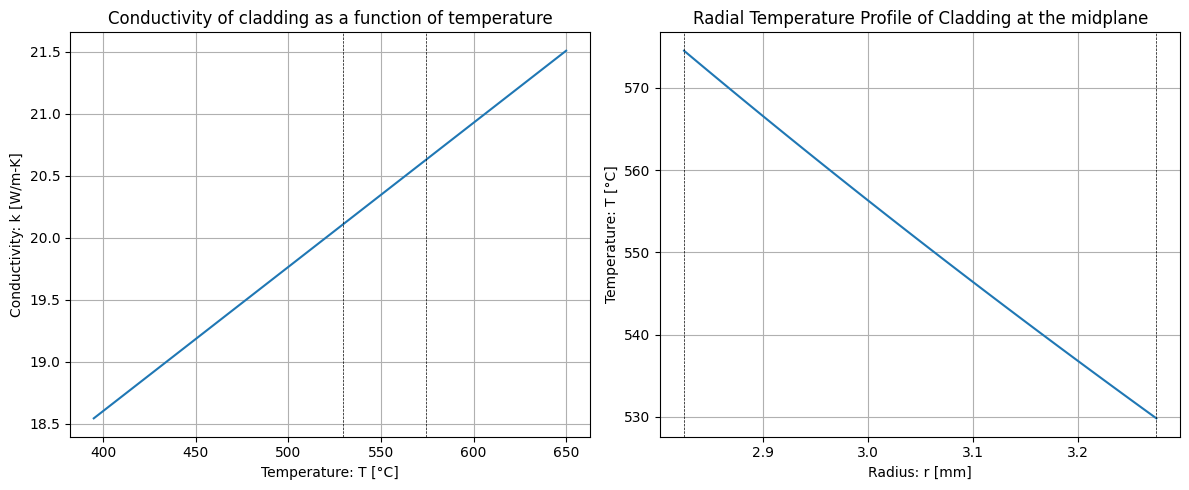

In [84]:
# RADIAL TEMPERATURE PROFILE OF CLADDING AT MIDPLANE

# Cladding thickness guess value
t_clad_i0 = 0.45 #[mm] Initial guess of cladding thickness

# Geometry of cladding
r_clad_out = D_clad_out/2 #[mm] External radius of cladding
r_clad_in = r_clad_out - t_clad_i0 #[mm] Internal radius of cladding

# Outer cladding temperature
T_co_avg0 = (T_co_in_K + T_co_out_K) / 2 #[K] Average temperature of coolant along the channel
T_clad_out0_K = q_l0*1e3 / (2 * np.pi * (r_clad_out/1000) * h_co) + T_co_avg0 #[K] Outer cladding temperature
T_clad_out0 = T_clad_out0_K - 273.15 #[°C]
print(f'Outer cladding temperature at the midplane: {T_clad_out0:.2f} [°C]')

def k_clad(T_clad):
  return 13.95 + 0.01163 * T_clad #[W/m-K] Thermal conductivity of cladding. Temparature in [°C]

# Radial temperature profile of the cladding at the midplane
def T_clad_r0(r_clad, k_clad):
    C = T_clad_out0 + (q_l0 * 1e3 * np.log(r_clad_out)) / (2 * np.pi * k_clad)
    return -(q_l0 * 1e3 * np.log(r_clad)) / (2 * np.pi * k_clad) + C

# Iterative correction for the average conductivitiy of the cladding at the midplane
k_clad_out_0 = k_clad(T_clad_out0) #[W/m-K]
k_clad_avg_0 = (k_clad_out_0 + k_clad_out_0)/2 #[W/m-K]  # Initial guess
iteration = 0
eps = 1e-4  # Convergence tolerance
max_iterations = 100  # To avoid infinite loops
print(f'Initial guess for the average thermal conductivity of cladding at the midplane: {k_clad_avg_0:.2f} [W/m-K]')

while True:
    iteration += 1
    T_clad_in_0 = T_clad_r0(r_clad_in, k_clad_avg_0)
    k_clad_in_0 = k_clad(T_clad_in_0)
    k_clad_avg_0_new = (k_clad_in_0 + k_clad_out_0) / 2

    if abs(k_clad_avg_0_new - k_clad_avg_0) < eps or iteration >= max_iterations:
        k_clad_avg_0 = k_clad_avg_0_new
        break

    k_clad_avg_0 = k_clad_avg_0_new

if iteration >= max_iterations:
    print("Warning: Maximum iterations reached without convergence")
print(f'Average thermal conductivity of the gap at the midplane: {k_clad_avg_0:.2f} [W/m-K]')

# Inner cladding temperature at midplane
T_clad_in0 = T_clad_r0(r_clad_in, k_clad_avg_0)
print(f'Inner cladding temperature at the midplane: {T_clad_in0:.2f} [°C]')

# Define range of values for graph cladding conductivity vs temperature
T_clad_values = np.linspace(T_co_in_C, 650, 100)
k_clad_values = k_clad(T_clad_values) #[W/m-K] Thermal conductivity of cladding

# Create a figure with two subplots arranged in 1 row and 2 columns
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
ax1.plot(T_clad_values, k_clad_values)
ax1.set_title('Conductivity of cladding as a function of temperature')
ax1.set_ylabel('Conductivity: k [W/m-K]')
ax1.set_xlabel('Temperature: T [°C]')
ax1.axvline(T_clad_in0, color = 'black', linewidth = 0.5, ls = '--')
ax1.axvline(T_clad_out0, color = 'black', linewidth = 0.5, ls = '--')
ax1.grid()

# Define range of values for graph cladding temperature vs radius
r_clad_values = np.linspace(r_clad_in, r_clad_out, 100)  #values along cladding thickness
T_clad_values = T_clad_r0(r_clad_values, k_clad_avg_0)

# Plot the results
ax2.plot(r_clad_values, T_clad_values)
ax2.set_title('Radial Temperature Profile of Cladding at the midplane')
ax2.set_xlabel('Radius: r [mm]')
ax2.set_ylabel('Temperature: T [°C]')
ax2.axvline(r_clad_out, color='black',linewidth=0.5, ls='--')
ax2.axvline(r_clad_in, color='black',linewidth=0.5, ls='--')
ax2.grid()

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

Outer gap temperature at the midplane: 574.50 [°C]
Initial guess for the average thermal conductivity of He at the midplane: 0.33 [W/m-K]
Average thermal conductivity of the gap at the midplane: 0.41 [W/m-K]
Inner gap temperature at the midplane: 1193.99 [°C]


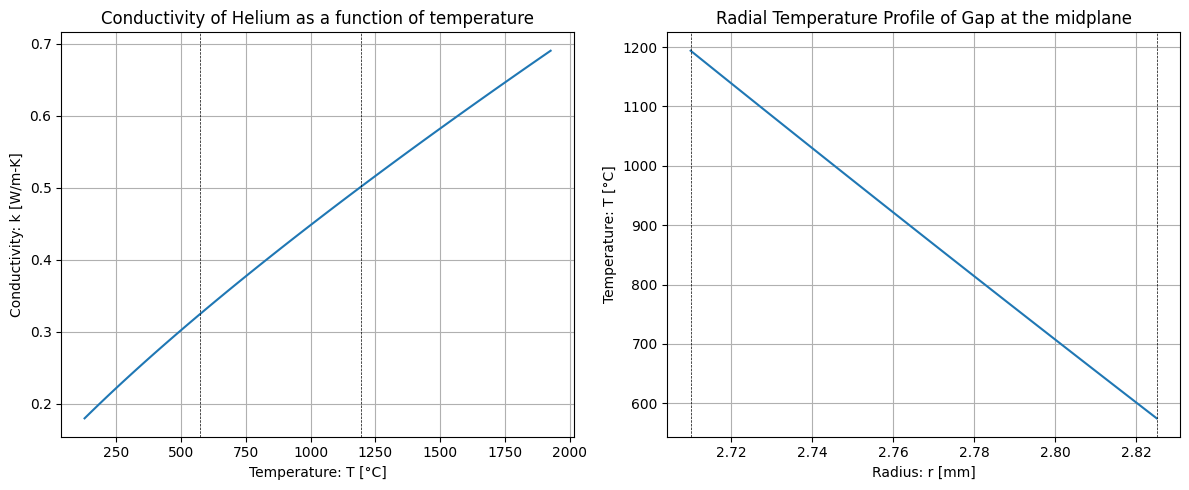

In [85]:
# RADIAL TEMPERATURE PROFILE OF GAP AT MIDPLANE

# Define constants
T_gap_out0_C = T_clad_in0 #[°C] Outer temperature of the gap at cladding side
r_gap_out = r_clad_in #[mm] Outer radius of the gap
r_gap_in = D_fuel_out/2 #[mm] Inner radius of the gap
T_gap_out0_K = T_gap_out0_C + 273.15 #[K] Outer temperature of gap
print(f'Outer gap temperature at the midplane: {T_gap_out0_C:.2f} [°C]')

def k_He(T_gap):
  return 15.8e-4 * T_gap**0.79 #[W/m-K] Average thermal conductivity of filling gas at midplane. T_gap in [K]

# Radial temperature profile of the gap at the midplane
def T_gap_K_0(r_gap, k_He):
    C = T_gap_out0_K + (q_l0 * 1e3 * np.log(r_gap_out)) / (2 * np.pi * k_He)
    return -(q_l0 * 1e3 * np.log(r_gap)) / (2 * np.pi * k_He) + C

# Iterative correction for the average conductivitiy of the gap at the midplane
k_He_out_0 = k_He(T_gap_out0_K) #[W/m-K]
k_He_avg_0 = (k_He_out_0 + k_He_out_0)/2 #[W/m-K]  # Initial guess
iteration = 0
eps = 1e-4  # Convergence tolerance
max_iterations = 100  # To avoid infinite loops
print(f'Initial guess for the average thermal conductivity of He at the midplane: {k_He_avg_0:.2f} [W/m-K]')

while True:
    iteration += 1
    T_gap_K_in_0 = T_gap_K_0(r_gap_in, k_He_avg_0)
    k_He_in_0 = k_He(T_gap_K_in_0)
    k_He_avg_0_new = (k_He_in_0 + k_He_out_0) / 2

    if abs(k_He_avg_0_new - k_He_avg_0) < eps or iteration >= max_iterations:
        k_He_avg_0 = k_He_avg_0_new
        break

    k_He_avg_0 = k_He_avg_0_new

if iteration >= max_iterations:
    print("Warning: Maximum iterations reached without convergence")
print(f'Average thermal conductivity of the gap at the midplane: {k_He_avg_0:.2f} [W/m-K]')

# Inner cladding temperature at midplane
T_gap_in0_C = T_gap_K_0(r_gap_in, k_He_avg_0) - 273.15 #[°C]
print(f'Inner gap temperature at the midplane: {T_gap_in0_C:.2f} [°C]')

# Define range of values for graph gap conductivity vs temperature
T_gap_values = np.linspace(400, 2200, 100) #[K]
k_gap_values = k_He(T_gap_values) #[W/m-K] Thermal conductivity of filling gas at different temperatures

# Create a figure with two subplots arranged in 1 row and 2 columns
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
ax1.plot(T_gap_values-273.15, k_gap_values)
ax1.set_title('Conductivity of Helium as a function of temperature')
ax1.set_ylabel('Conductivity: k [W/m-K]')
ax1.set_xlabel('Temperature: T [°C]')
ax1.axvline(T_gap_in0_C, color = 'black', linewidth = 0.5, ls = '--')
ax1.axvline(T_gap_out0_C, color = 'black', linewidth = 0.5, ls = '--')
ax1.grid()

# Define range of values for graph gap temperature vs radius
r_gap_values = np.linspace(r_gap_in, r_gap_out, 100)  #values along cladding thickness
T_gap_C_values = T_gap_K_0(r_gap_values, k_He_avg_0) - 273.15 #[°C]

# Plot the results
ax2.plot(r_gap_values, T_gap_C_values)
ax2.set_title('Radial Temperature Profile of Gap at the midplane')
ax2.set_xlabel('Radius: r [mm]')
ax2.set_ylabel('Temperature: T [°C]')
ax2.axvline(r_gap_out, color='black',linewidth=0.5, ls='--')
ax2.axvline(r_gap_in, color='black',linewidth=0.5, ls='--')
ax2.grid()

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

Maximum temperature at external wall of cladding: 636.62 [°C] at H = 558.48 (out of the active section) [mm]
Maximum temperature at internal wall of cladding: 649.69 [°C] at H = 427.59 (out of the active section) [mm]
Maximum temperature at the midwall of the cladding: 641.07 [°C] at H = 492.09 (out of the active section) [mm]
Maximum temperature at external wall of fuel (estimation): 3056.89 [°C] at H = 67.51 (out of the active section) [mm]
Temperature of coolant at midplane: 515.38 [°C]
Outer wall temperature of cladding at midplane: 529.83 [°C]
Inner wall temperature of cladding at midplane: 574.96 [°C]


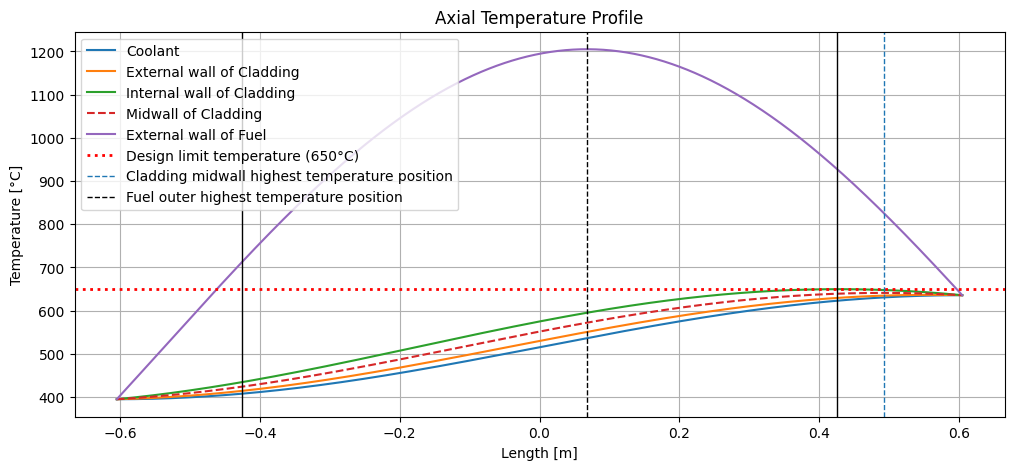

In [86]:
# AXIAL TEMPERATURE PROFILE OF COOLANT, CLADDING AND GAP

# Design limit for the cladding
T_clad_limit = 650 #[°C] Maximum temperature of the cladding

# Define radial positions
r_clad_mw = (r_clad_in + r_clad_out)/2 #[mm] Midwall position of the cladding
r_gap_in = D_fuel_out/2 #[mm] Inner radius of the gap

# Axial temperature profile of the coolant
def T_co_z(z):
    C = T_co_in_C - q_l0/2 * 1e3 * np.sin(- np.pi / 2) * H_ext / (m_co_in * cp_co_avg * np.pi)
    return q_l0 * 1e3 * np.sin(np.pi * z / H_ext) * H_ext / (2 * m_co_in * cp_co_avg * np.pi) + C #[°C] The heat transferred is the half of one pin

# Axial temperature profile of the outer wall of the cladding
def T_clad_out_z(z):
    return q_l0*1e3 * np.cos(np.pi * z / H_ext) / (2 * np.pi * (r_clad_out/1000) * h_co) + T_co_z(z)

# Temperature profile of the cladding as a function of radial and axial position
def T_clad(r_clad, k_clad, z):
    return T_clad_out_z(z) + q_l0*1e3 * np.cos(np.pi * z / H_ext) * np.log(r_clad_out/r_clad)  / (2*np.pi * k_clad)

# Define average conductivity of the cladding
T_clad_out_avg = (T_clad_out_z(-H_act/2) + T_clad_out_z(H_act/2))/2
k_clad_out_avg = k_clad(T_clad_out_avg) #[W/m-K]
k_clad_avg = (k_clad_out_avg + k_clad_avg_0)/2 #[W/m-K]

# Temperature profile of the gap as a function of radius and axial coordinate
def T_gap_K(r_gap, k_He, z):
    C = (T_clad(r_clad_in, k_clad_avg, z) + 273.15) + q_l0*1e3 * np.cos(np.pi * z / H_ext) * np.log(r_gap_out) / (2 * np.pi * k_He)
    return -(q_l0*1e3 *np.cos(np.pi * z / H_ext) * np.log(r_gap)) / (2 * np.pi * k_He) + C

# Define the range of z_clad values
z_values = np.linspace(-H_ext/2, H_ext/2, 1000)  #[m]

# Calculate the axial temperature profiles
T_co_values = T_co_z(z_values)
T_clad_out_values = T_clad_out_z(z_values)
T_clad_in_values = T_clad(r_clad_in, k_clad_avg, z_values)
T_clad_mw_values = T_clad(r_clad_mw, k_clad_avg, z_values)
T_gap_in_values = T_gap_K(r_gap_in, k_He_avg_0, z_values) - 273.15 #[°C] Initial calculation with k_He_avg_0 to estimate hottest point of the fuel surface

# Calculate the maximum temperature
T_clad_out_res = minimize_scalar(lambda z: - T_clad_out_z(z), bounds=(-H_ext/2, H_ext/2), method='bounded')
T_clad_out_max = T_clad_out_z(T_clad_out_res.x)
T_clad_in_res = minimize_scalar(lambda z: - T_clad(r_clad_in, k_clad_avg, z), bounds=(-H_ext/2, H_ext/2), method='bounded')
T_clad_in_max = T_clad(r_clad_in, k_clad_avg, T_clad_in_res.x)
T_clad_mw_res = minimize_scalar(lambda z: - T_clad(r_clad_mw, k_clad_avg, z), bounds=(-H_ext/2, H_ext/2), method='bounded')
T_clad_mw_max = T_clad(r_clad_mw, k_clad_avg, T_clad_mw_res.x)
T_gap_in_res = minimize_scalar(lambda z: - T_gap_K(r_gap_in, k_He_avg_0, z), bounds=(-H_ext/2, H_ext/2), method='bounded')
T_gap_in_max = T_clad(r_gap_in, k_He_avg_0, T_gap_in_res.x) - 273.15

# Print results the maximum temperature
print(f'Maximum temperature at external wall of cladding: {T_clad_out_max:.2f} [°C] at H = {T_clad_out_res.x*1000:.2f} (out of the active section) [mm]')
print(f'Maximum temperature at internal wall of cladding: {T_clad_in_max:.2f} [°C] at H = {T_clad_in_res.x*1000:.2f} (out of the active section) [mm]')
print(f'Maximum temperature at the midwall of the cladding: {T_clad_mw_max:.2f} [°C] at H = {T_clad_mw_res.x*1000:.2f} (out of the active section) [mm]')
print(f'Maximum temperature at external wall of fuel (estimation): {T_gap_in_max:.2f} [°C] at H = {T_gap_in_res.x*1000:.2f} (out of the active section) [mm]')
print(f'Temperature of coolant at midplane: {T_co_z(0):.2f} [°C]')
print(f'Outer wall temperature of cladding at midplane: {T_clad_out_z(0):.2f} [°C]')
print(f'Inner wall temperature of cladding at midplane: {T_clad(r_clad_in, k_clad_avg, 0):.2f} [°C]')

# Plot the results
plt.figure(figsize=(12, 5))   # Set the figure size
plt.plot(z_values, T_co_values, label = 'Coolant')  # r_fuel is already in mm
plt.plot(z_values, T_clad_out_values, label = 'External wall of Cladding')  # r_fuel is already in mm
plt.plot(z_values, T_clad_in_values, label = 'Internal wall of Cladding')  # r_fuel is already in mm
plt.plot(z_values, T_clad_mw_values, label = 'Midwall of Cladding', ls = '--')  # r_fuel is already in mm
plt.plot(z_values, T_gap_in_values, label = 'External wall of Fuel')  # r_fuel is already in mm
plt.title('Axial Temperature Profile')
plt.xlabel('Length [m]')
plt.ylabel('Temperature [°C]')
plt.axhline(T_clad_limit, color = 'red', linestyle = ':', linewidth = 2, label ='Design limit temperature (650°C)')
plt.axvline(T_clad_mw_res.x, linestyle = '--', linewidth = 1.0, label ='Cladding midwall highest temperature position')
plt.axvline(T_gap_in_res.x, color = 'black', linestyle = '--', linewidth = 1.0, label ='Fuel outer highest temperature position')
plt.axvline(-H_act/2/1000, color='black',linewidth=1.0, ls='-')
plt.axvline(H_act/2/1000, color='black',linewidth=1.0, ls='-')
plt.legend()
plt.grid()
plt.show()

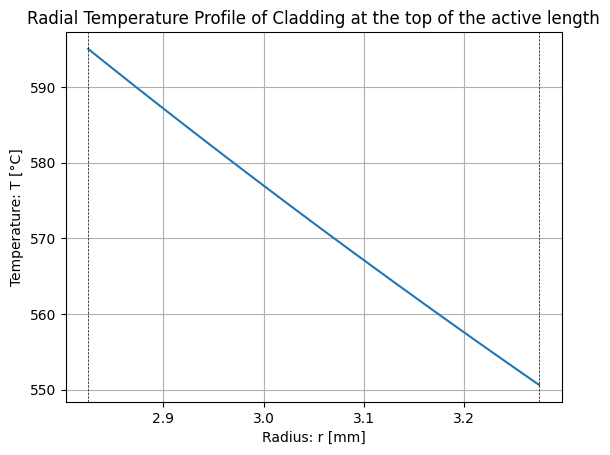

In [87]:
# RADIAL TEMPERATURE PROFILE OF CLADDING AT THE HOTTEST POINT

# Define constants
z_hot = T_gap_in_res.x #[m] Axial coordinate of the hottest point
T_clad_hot_values = T_clad(r_clad_values, k_clad_avg, z_hot)

# Plot the results
plt.plot(r_clad_values, T_clad_hot_values)
plt.title('Radial Temperature Profile of Cladding at the top of the active length')
plt.xlabel('Radius: r [mm]')
plt.ylabel('Temperature: T [°C]')
plt.axvline(r_clad_out, color='black',linewidth=0.5, ls='--')
plt.axvline(r_clad_in, color='black',linewidth=0.5, ls='--')
plt.grid()
plt.show()

Prior code was wrong:

for _ in range(1000):
    T_gap_avg_max = (T_gap_in_max_K + T_gap_out_max_K) / 2 #[K] Average temperature of the gap at the top of the active length
    k_He_avg_max = 15.8e-4 * T_gap_avg_max**0.79 #[W/m-K] Average thermal conductivity of filling gas at midplane
    T_gap_in_max_K_new = T_gap_out_max_K + (q_l0 * 1e3 * np.log(r_gap_out / r_gap_in)) / (2 * np.pi * k_He_avg_max) #[K] i-th iteration for inner temperature of the gap

    if abs(T_gap_in_max_K_new - T_gap_in_max_K) < 0.1:  # Check for convergence
        break
    T_gap_in_max_K = T_gap_in_max_K_new #[K] Update inner temperature of gap

T_gap_in_max_C = T_gap_in_max_K - 273.15 #[°C] Inner temperature of the gap at the top of the active length

print(f"Inner gap temperature at the top of the active length (T_gap_in): {T_gap_in_max_C:.2f} [°C]")
print(f"Average conductivity of the gap at the top of the active length (k_gap_avg): {k_He_avg_max:.2f} [W/m-K]")

It is considering the linear heat at the midwall to calculate the maximum temperature of the gap in the axial direction. However, the linear heat is also function of z and it decreases outwards.

Outer gap temperature at the hottest axial position for the fuel: 595.06 [°C]
Initial guess for the average thermal conductivity of He at the midplane: 0.33 [W/m-K]
Average thermal conductivity of the gap at the midplane: 0.42 [W/m-K]
Inner gap temperature at the hottest axial position: 1199.42 [°C]


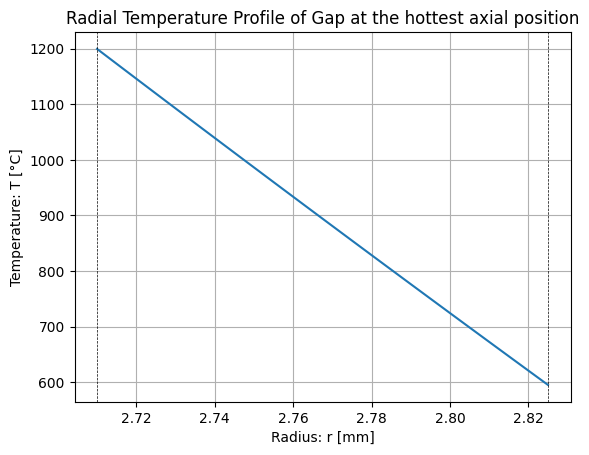

In [88]:
# RADIAL TEMPERATURE PROFILE OF GAP AT THE HOTTEST POINT

# Define constants
z_hot = T_gap_in_res.x #[m] Axial coordinate of the hottest point
T_gap_out_hot_C = T_clad(r_clad_in, k_clad_avg, z_hot) #[°C] Outer temperature of the gap at cladding side
T_gap_out_hot_K = T_gap_out_hot_C + 273.15 #[K] Outer temperature of gap
print(f'Outer gap temperature at the hottest axial position for the fuel: {T_gap_out_hot_C:.2f} [°C]')

# Temperature profile of the gap as a function of radius and axial coordinate
def T_gap_K(r_gap, k_He, z):
    C = (T_clad(r_clad_in, k_clad_avg, z) + 273.15) + q_l0*1e3 * np.cos(np.pi * z / H_ext) * np.log(r_gap_out) / (2 * np.pi * k_He)
    return -(q_l0*1e3 *np.cos(np.pi * z / H_ext) * np.log(r_gap)) / (2 * np.pi * k_He) + C

# Iterative correction for the average conductivitiy of the gap at the hottest point
k_He_out_hot = k_He(T_gap_out_hot_K) #[W/m-K]
k_He_avg_hot = (k_He_out_hot + k_He_out_hot)/2 #[W/m-K]  # Initial guess
iteration = 0
eps = 1e-4  # Convergence tolerance
max_iterations = 100  # To avoid infinite loops
print(f'Initial guess for the average thermal conductivity of He at the midplane: {k_He_avg_hot:.2f} [W/m-K]')

while True:
    iteration += 1
    T_gap_K_in_hot = T_gap_K(r_gap_in, k_He_avg_hot, z_hot)
    k_He_in_hot = k_He(T_gap_K_in_hot)
    k_He_avg_hot_new = (k_He_in_hot + k_He_out_hot) / 2

    if abs(k_He_avg_hot_new - k_He_avg_hot) < eps or iteration >= max_iterations:
        k_He_avg_hot = k_He_avg_hot_new
        break

    k_He_avg_hot = k_He_avg_hot_new # This value can be used to manually iterate over the axial profile of the gap

if iteration >= max_iterations:
    print("Warning: Maximum iterations reached without convergence")
print(f'Average thermal conductivity of the gap at the midplane: {k_He_avg_hot:.2f} [W/m-K]')

# Inner cladding temperature at the top of the active length
T_gap_in_hot_C = T_gap_K(r_gap_in,  k_He_avg_hot, z_hot) - 273.15 #[°C]
print(f'Inner gap temperature at the hottest axial position: {T_gap_in_hot_C:.2f} [°C]')

# Define range of values for graph gap temperature vs radius
T_gap_hot_values = T_gap_K(r_gap_values, k_He_avg_hot, z_hot) - 273.15 #[°C]

# Plot the results
plt.plot(r_gap_values, T_gap_hot_values)
plt.title('Radial Temperature Profile of Gap at the hottest axial position')
plt.xlabel('Radius: r [mm]')
plt.ylabel('Temperature: T [°C]')
plt.axvline(r_gap_out, color='black',linewidth=0.5, ls='--')
plt.axvline(r_gap_in, color='black',linewidth=0.5, ls='--')
plt.grid()
plt.show()

The thermal conductivity of the fuel changes with change in temperature with the following relation:

\begin{equation}
\int_{T_{fo}}^{T(r)}k(T)dT = \frac{q'}{4π}*(1-(\frac{r}{r_{fo}})^2)
\end{equation}

Using the relations provided in the pdf, k(T) is given by:
\begin{equation}
k(T) = 1.755+(k_0-1.755)*exp(\frac{β}{128.15})
\end{equation}

\begin{equation}
k_0(T) = (\frac{1}{A+B*T(K)} + \frac{D}{T^2(K)}*exp(\frac{E}{T(K))}))*(1-p)^2
\end{equation}

\begin{equation}
A=0.01926+1.06*10^{-6}*x +2.63*10^{-8}
\end{equation}

\begin{equation}
B=2.39*10^{-4} + 1.37*10^{-13}
\end{equation}

\begin{equation}
D=5.27*10^{9}
\end{equation}

\begin{equation}
E=17109.5
\end{equation}

The term x used in A is the deviation	from	stoichiometry and is calculated as:
\begin{equation}
x=2-O/M
\end{equation}

Takin all of the previous equations into account, and solving the integral we get an equation that cannot be solved analytically, but only numerically.

\begin{equation}
1.755(T(r)-T_1)(1-e^x)+(1-p)^{2.5}(\frac{ln(B*T(r)+A)}{B}-\frac{ln(B*T_{fo})+A)}{B}+D*\frac{e^{-E/T(r)}-e^{-E/T_{fo}}}{E}) = \frac{q'}{4π}(1-(\frac{r}{r_{fo}})^2)
\end{equation}

Outer fuel temperature at the hottest axial position: 1199.42 [°C]
Initial guess for the average thermal conductivity at the hottest axial position: 2.14 [W/m-K]
Average thermal conductivity at the hottest axial position: 2.22 [W/m-K]
Maximum temperature at fuel: 2562.84 [°C]


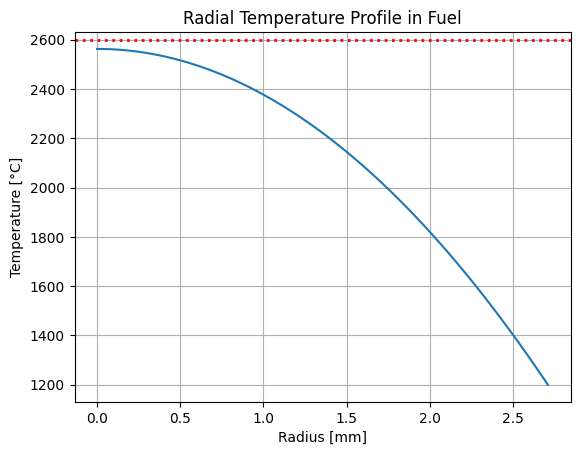

In [89]:
# RADIAL TEMPERATURE PROFILE OF FUEL AT THE HOTTEST POINT

# Design limit
T_fuel_limit = 2600 #[°C] Maximum temperature of fuel

# Inputs
T_fuel_out_K_hot = T_gap_in_hot_C + 273.15  #[K] Estimated maximum outer fuel temperature
r_fuel_out_0 = D_fuel_out/2 #[mm] Radius of fuel pellet at initial time
z_hot = T_gap_in_res.x #[m] Axial coordinate of the hottest point
p = 0.055 #[/] porosity
beta = beta #[GWd/t_HM] Burnup of fuel after one cycle
x_Pu_0 = 0.29 #[%wt] Initial composion of Pu in the fuel
OM_ratio_0 = 1.957 #[/] Oxygen-to-metal ratio at time 0
x_dev_0 = 2 - OM_ratio_0 #[/] Deviation from stoichoimetry at time 0

print(f'Outer fuel temperature at the hottest axial position: {T_fuel_out_K_hot - 273.15:.2f} [°C]')

# Fuel thermal conductivity (k_0) as a function of temperature and composition
def k_fuel(T_fuel_K, x_dev, x_Pu, p, beta):
    A = 0.01926 + 1.06e-6*x_dev + 2.63e-8*x_Pu
    B = 2.39e-4 + 1.37e-13*x_Pu
    D = 5.27e9
    E = 17109.5
    k_fuel_0 = (1 / (A + B*T_fuel_K) + D / (T_fuel_K**2) * np.exp(-E / T_fuel_K)) * (1 - p)**2.5
    return 1.755 + (k_fuel_0 - 1.755) * np.exp(-beta / 128.75) #[W/m-K] Thermal conductivity of MOX fuel

# Define the temperature profile function
def T_fuel_K(r_fuel, z, k_fuel):
    C1 = (q_l(z) * 1e3 )/ (4 * np.pi * k_fuel) #[K]
    F_v = (1-(r_fuel/r_fuel_out_0)**2)
    return T_fuel_out_K_hot + C1 * F_v #[K] Radial temperature profile of fuel at hottest point at time 0

# Iterative correction for the average conductivitiy
k_fuel_out_0 = k_fuel(T_fuel_out_K_hot, x_dev_0, x_Pu_0, p, beta) #[W/m-K]
k_fuel_avg = (k_fuel_out_0 + k_fuel_out_0)/2 #[W/m-K]  # Initial guess
iteration = 0
eps = 1e-4  # Convergence tolerance
max_iterations = 100  # To avoid infinite loops
print(f'Initial guess for the average thermal conductivity at the hottest axial position: {k_fuel_avg:.2f} [W/m-K]')

while True:
    iteration += 1
    T_fuel_K_hot = T_fuel_K(0, z_hot, k_fuel_avg)
    k_fuel_in_0 = k_fuel(T_fuel_K_hot, x_dev_0, x_Pu_0, p, beta)
    k_fuel_avg_new = (k_fuel_in_0 + k_fuel_out_0) / 2

    if abs(k_fuel_avg_new - k_fuel_avg) < eps or iteration >= max_iterations:
        k_fuel_avg = k_fuel_avg_new
        break

    k_fuel_avg = k_fuel_avg_new

if iteration >= max_iterations:
    print("Warning: Maximum iterations reached without convergence")
print(f'Average thermal conductivity at the hottest axial position: {k_fuel_avg:.2f} [W/m-K]')

# Define the range of r_fuel values (from 0 to r_fuel_ext, in mm)
r_fuel_values = np.linspace(0, r_fuel_out_0, 100)  # r_fuel is in mm

# Calculate the temperature profile
T_fuel_hot_values = T_fuel_K(r_fuel_values, z_hot, k_fuel_avg) - 273.15 #[°C]

# Calculate the maximum temperature
print(f'Maximum temperature at fuel: {T_fuel_K(0, z_hot, k_fuel_avg) - 273.15:.2f} [°C]')

# Plot the results
plt.plot(r_fuel_values, T_fuel_hot_values)  # r_fuel is already in mm
plt.title('Radial Temperature Profile in Fuel')
plt.xlabel('Radius [mm]')
plt.ylabel('Temperature [°C]')
plt.axhline(T_fuel_limit, color = 'red', linestyle = ':', linewidth = 2, label ='Design limit temperature (2600°C)')
plt.grid()
plt.show()

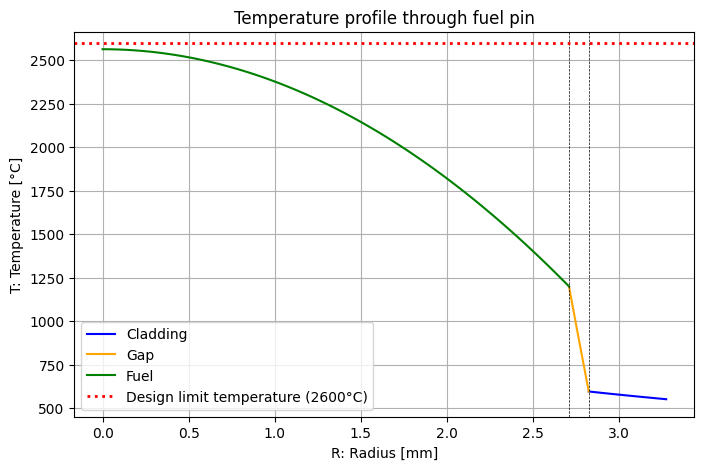

In [90]:
# RADIAL TEMPERATURE PROFILE AT THE ESTIMATED HOTTEST POINT

# Plotting multiple graphs
plt.figure(figsize=(8, 5))   # Set the figure size
plt.plot(r_clad_values, T_clad_hot_values, label = 'Cladding', color = 'blue')
plt.plot(r_gap_values, T_gap_hot_values, label = 'Gap', color = 'orange')
plt.plot(r_fuel_values, T_fuel_hot_values, label = 'Fuel', color = 'green')
plt.title('Temperature profile through fuel pin')
plt.xlabel('R: Radius [mm]')
plt.ylabel('T: Temperature [°C]')
plt.axvline(r_clad_in, color='black',linewidth=0.5, ls='--')
plt.axvline(r_fuel_out_0, color='black',linewidth=0.5, ls='--')
plt.axhline(T_fuel_limit, color = 'red', linestyle = ':', linewidth = 2, label ='Design limit temperature (2600°C)')
plt.grid()
plt.legend()
plt.show()